<a href="https://colab.research.google.com/github/vincentmin/hello_world/blob/master/my_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

First off, let's load up and prepare our data. This time, we're going to work with multiple features, so we'll modularize the logic for preprocessing the features a bit:

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

my_dataframe = pd.read_csv("http://seppe.net/aa/assignment2/data/train.csv", sep=",")

my_dataframe = my_dataframe.reindex(
np.random.permutation(my_dataframe.index))

In [20]:
# Fill in some missing values.
mean_weight = my_dataframe["weight"].mean()
my_dataframe["weight"].loc[my_dataframe["weight"].isnull()] = mean_weight
my_dataframe["detachable_keyboard"].loc[my_dataframe["detachable_keyboard"].isnull()] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
my_dataframe.describe()

,id,screen_size,pixels_x,pixels_y,touchscreen,detachable_keyboard,discrete_gpu,ram,ssd,storage,weight,min_price,max_price
count,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0,510.0
mean,21748.8,14.6,1866.0,1074.6,0.3,0.0,0.3,9.6,198.9,574.7,4.2,793.7,829.2
std,7344.3,1.6,565.1,354.3,0.5,0.2,0.5,6.2,244.4,517.4,1.3,543.6,570.1
min,3841.0,10.1,1280.0,768.0,0.0,0.0,0.0,2.0,0.0,16.0,1.4,69.0,76.0
25%,18547.8,13.3,1366.0,768.0,0.0,0.0,0.0,4.0,0.0,128.0,3.0,380.1,399.2
50%,23196.5,15.6,1920.0,1080.0,0.0,0.0,0.0,8.0,128.0,500.0,4.3,638.5,649.0
75%,27881.5,15.6,1920.0,1080.0,1.0,0.0,1.0,16.0,256.0,1000.0,4.9,1099.7,1179.7
max,31422.0,17.3,3840.0,2160.0,1.0,1.0,1.0,64.0,2000.0,4000.0,9.7,2999.1,2999.1


In [0]:
def preprocess_features(my_dataframe):
  """Prepares input features from California housing data set.

  Args:
    my_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = my_dataframe[
    ["screen_size",
     "ram",
     "ssd",
     "storage",
     "weight"]]

  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["pixel_density"] = ((my_dataframe["pixels_x"]*my_dataframe["pixels_y"])/(1000*my_dataframe["screen_size"]*my_dataframe["screen_size"]))
  return processed_features

def preprocess_targets(my_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    my_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["average_price"] =  ((my_dataframe["min_price"]+my_dataframe["max_price"])/2)
  return output_targets

For the **training set**, we'll choose the first 350 examples, out of the total of 510.

In [26]:
training_examples = preprocess_features(my_dataframe.head(350))
training_examples.describe()

,screen_size,ram,ssd,storage,weight,pixel_density
count,350.0,350.0,350.0,350.0,350.0,350.0
mean,14.8,9.6,189.4,576.1,4.3,10.6
std,1.6,6.1,240.5,486.4,1.4,8.8
min,10.1,2.0,0.0,16.0,1.4,4.3
25%,13.5,4.5,0.0,256.0,3.1,5.4
50%,15.6,8.0,128.0,500.0,4.4,8.5
75%,15.6,16.0,256.0,1000.0,5.0,10.6
max,17.3,64.0,2000.0,4000.0,9.7,46.9


In [28]:
training_targets = preprocess_targets(my_dataframe.head(350))
training_targets.describe()

,average_price
count,350.0
mean,800.4
std,524.3
min,73.0
25%,396.7
50%,649.0
75%,1124.3
max,2495.0


For the **validation set**, we'll choose the last 160 examples, out of the total of 510.

In [29]:
validation_examples = preprocess_features(my_dataframe.tail(160))
validation_examples.describe()

,screen_size,ram,ssd,storage,weight,pixel_density
count,160.0,160.0,160.0,160.0,160.0,160.0
mean,14.4,9.7,219.7,571.7,4.0,11.1
std,1.7,6.5,252.4,581.2,1.2,8.3
min,10.1,2.0,0.0,16.0,1.7,4.3
25%,13.3,4.0,16.0,128.0,3.0,5.8
50%,15.6,8.0,128.0,410.0,4.1,8.5
75%,15.6,16.0,256.0,1000.0,4.8,10.9
max,17.3,32.0,1000.0,2512.0,8.8,46.9


In [30]:
validation_targets = preprocess_targets(my_dataframe.tail(160))
validation_targets.describe()

,average_price
count,160.0
mean,835.6
std,619.6
min,87.9
25%,392.3
50%,600.0
75%,1192.0
max,2999.1


## Task 4: Train and Evaluate a Model

**Spend 5 minutes or so trying different hyperparameter settings.  Try to get the best validation performance you can.**

Next, we'll train a linear regressor using all the features in the data set, and see how well we do.

Let's define the same input function we've used previously for loading the data into a TensorFlow model.


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a separate function. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercises.)

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

Next, go ahead and complete the `train_model()` code below to set up the input functions and calculate predictions.

**NOTE:** It's okay to reference the code from the previous exercises, but make sure to call `predict()` on the appropriate data sets.

Compare the losses on training data and validation data. With a single raw feature, our best root mean squared error (RMSE) was of about 180.

See how much better you can do now that we can use multiple features.

Check the data using some of the methods we've looked at before.  These might include:

   * Comparing distributions of predictions and actual target values

   * Creating a scatter plot of predictions vs. target values

   * Creating two scatter plots of validation data using `latitude` and `longitude`:
      * One plot mapping color to actual target `median_house_value`
      * A second plot mapping color to predicted `median_house_value` for side-by-side comparison.

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  

  # 1. Create input functions. # YOUR CODE HERE
  training_input_fn = lambda: my_input_fn(training_examples,
    training_targets["average_price"],
    batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples,
    training_targets["average_price"],
    num_epochs=1,
    shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
    validation_targets["average_price"],
    num_epochs=1,
    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.    # YOUR CODE HERE
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)       
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  _ = plt.plot()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 925.31
  period 01 : 894.85
  period 02 : 864.88
  period 03 : 835.57
  period 04 : 806.96
  period 05 : 779.02
  period 06 : 751.91
  period 07 : 725.66
  period 08 : 700.52
  period 09 : 676.41
Model training finished.


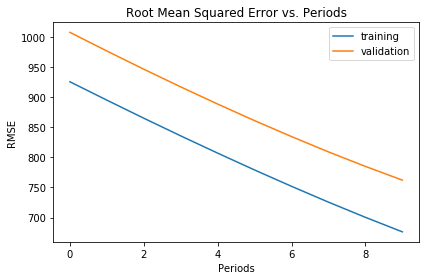

In [37]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.0001,
    steps=1000,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for a solution.

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [0]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 5: Evaluate on Test Data

**In the cell below, load in the test data set and evaluate your model on it.**

We've done a lot of iteration on our validation data.  Let's make sure we haven't overfit to the pecularities of that particular sample.

Test data set is located [here](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

How does your test performance compare to the validation performance?  What does this say about the generalization performance of your model?

In [38]:
test_data = pd.read_csv("http://seppe.net/aa/assignment2/data/test.csv", sep=",")

test_examples = preprocess_features(test_data)
test_targets = preprocess_targets(test_data)


test_input_function=lambda: my_input_fn(test_examples,
    test_targets["average_price"],
    num_epochs=1,
    shuffle=False)
test_predictions = linear_regressor.predict(input_fn=test_input_function)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_predictions = np.clip(test_predictions,0,500)

plt.scatter(test_predictions,test_targets["average_price"])
plt.show()

KeyError: ignored

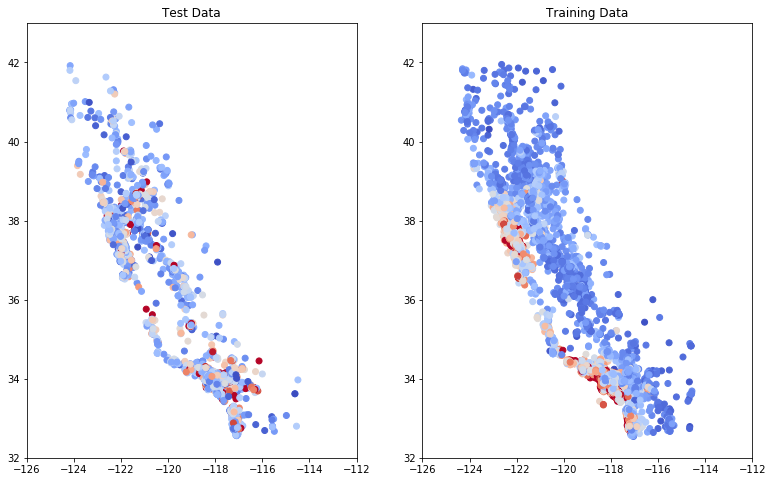

Final RMSE (on test data): 146.24


In [0]:
  plt.figure(figsize=(13, 8))

  ax = plt.subplot(1, 2, 1)
  ax.set_title("Test Data")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(test_examples["longitude"],
            test_examples["latitude"],
            cmap="coolwarm",
            c=test_predictions / test_predictions.max())

  ax = plt.subplot(1,2,2)
  ax.set_title("Training Data")

  ax.set_autoscaley_on(False)
  ax.set_ylim([32, 43])
  ax.set_autoscalex_on(False)
  ax.set_xlim([-126, -112])
  plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

  plt.show()
  root_mean_squared_error = math.sqrt(
  metrics.mean_squared_error(test_predictions, test_targets))
  print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

### Solution

Click below for the solution.

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 161.52
